# Riccardo Rorato
# Computational Vision Project
## Plankton as Biosensor (Task 2)
### Introduction
The goal of this project is to design a set of descriptors to characterize plankton cell
morphology from images. Such descriptors will be used to train an anomaly detection algorithm
(e.g., one-class SVM, isolation forest) so that each class can be accurately distinguished
from the others. One anomaly detector will be trained for each of the available classes. The
descriptors can be extracted from shape (e.g., image moments, Hu moments, geometric
features as area or perimeter) and texture (e.g., features from the gray level histogram, haralick
features, etc.). Those same features will be then compared to understand which ones improve the
anomaly detection the most.

Let us consider the 5 most "different" plankton types as classes for simplicity, those will be:
- Volvox
- Paramecium Bursaria
- Didinium Nasutum
- Arcella Vulgaris
- Stentor Coeruleus

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.color

# link to the dataset to download:
# https://ibm.ent.box.com/v/PlanktonData

volvox_train_path = ".\DATA\LENSLESS DATASET\TRAIN_IMAGE\VOLVOX"
paramecium_train_path = ".\DATA\LENSLESS DATASET\TRAIN_IMAGE\PARAMECIUM  BURSARIA"
didinium_train_path = ".\DATA\LENSLESS DATASET\TRAIN_IMAGE\DIDINIUM NASUTUM"
arcella_train_path = ".\DATA\LENSLESS DATASET\TRAIN_IMAGE\ARCELLA VULGARIS"
stentor_train_path = ".\DATA\LENSLESS DATASET\TRAIN_IMAGE\STENTOR COERULEUS"

# load the training set images
def load_images_from_folder(folder, binarize=False):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            if binarize:
                gray_image = skimage.color.rgb2gray(img)
                img = (gray_image > 0.5).astype(np.uint8) * 255
            images.append(img)
    return images

volvox_train = load_images_from_folder(volvox_train_path)
paramecium_train = load_images_from_folder(paramecium_train_path)
didinium_train = load_images_from_folder(didinium_train_path)
arcella_train = load_images_from_folder(arcella_train_path)
stentor_train = load_images_from_folder(stentor_train_path)

In [2]:
# balanced dataset, 500 images each
print(len(volvox_train))
print(len(paramecium_train))
print(len(didinium_train))
print(len(arcella_train))
print(len(stentor_train))

500
500
500
500
500


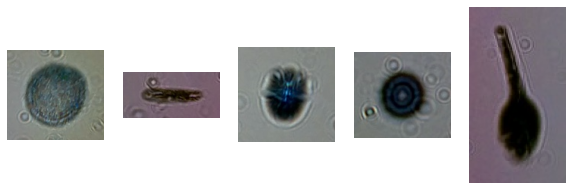

In [3]:
# show a sample of all plankton types
f, axarr = plt.subplots(1,5, figsize=(10,10))
[ax.set_axis_off() for ax in axarr]
axarr[0].imshow(volvox_train[0])
axarr[1].imshow(paramecium_train[0])
axarr[2].imshow(didinium_train[0])
axarr[3].imshow(arcella_train[0])
axarr[4].imshow(stentor_train[0])
plt.show()

The 5 types of plankton look pretty different with respect to at least 1 aspect: the Stentor has a shape with a "tail", and the ones that have a circular shape have a pretty different pattern that distinguishes them. These aspects are going to be useful in designing proper features to distinguish them.

To help with the extraction of such features, we also have the binarized version of the same dataset.

In [4]:
volvox_train_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TRAIN_IMAGEBIN\VOLVOX", binarize=True)
paramecium_train_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TRAIN_IMAGEBIN\PARAMECIUM  BURSARIA", binarize=True)
didinium_train_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TRAIN_IMAGEBIN\DIDINIUM NASUTUM", binarize=True)
arcella_train_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TRAIN_IMAGEBIN\ARCELLA VULGARIS", binarize=True)
stentor_train_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TRAIN_IMAGEBIN\STENTOR COERULEUS", binarize=True)

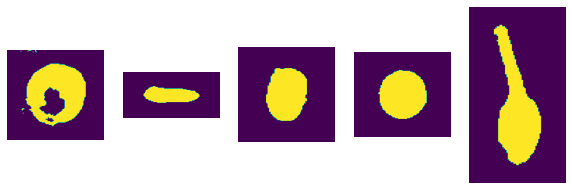

In [5]:
f, axarr = plt.subplots(1,5, figsize=(10,10))
[ax.set_axis_off() for ax in axarr]
axarr[0].imshow(volvox_train_bin[0])
axarr[1].imshow(paramecium_train_bin[0])
axarr[2].imshow(didinium_train_bin[0])
axarr[3].imshow(arcella_train_bin[0])
axarr[4].imshow(stentor_train_bin[0])
plt.show()

# Features extraction
### Geometric features
Geometric features are features extracted from the geometrical properties of the object: its shape and size, circularity, perimeter and area, characteristics of the enclosing rectangle and ellipse...

To do that, we will have to compute the contours of the plankton:

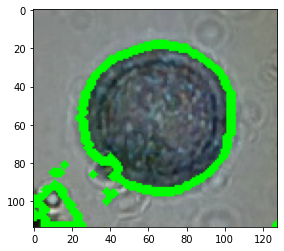

In [6]:
img1 = volvox_train[190].copy()
img1_bin = volvox_train_bin[190].copy()
# cv2.RETR_EXTERNAL makes us select contours just in the external part of each obj: no contour contains another one
# cv2.CHAIN_APPROX_NONE to store all the points of the contour (no approximations on straight lines)
contours, _ = cv2.findContours(img1_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img1, contours, -1, (0, 255, 0), 3)
plt.imshow(img1)
plt.show()

We can see how in some cases the thresholding is not a pure "segementation" of the plankton organism (findContours will return a tuple of more than 1 connected contour), so we will have to select the contour which has the biggest enclosing area:

In [7]:
def contour_of_biggest_area(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_area = 0
    res = None
    # iterate through all detected blobs/objects/contours
    for cont in contours:
        bbox = cv2.boundingRect(cont) # coordinates of corner points
        # area of current object is the number of "white"/255 pixels inside that bounding box
        area = np.count_nonzero(img[bbox[1]:(bbox[1] + bbox[3]), bbox[0]:(bbox[0] + bbox[2])] == 255)
        if area > max_area:
            max_area = area
            res = cont
    return res

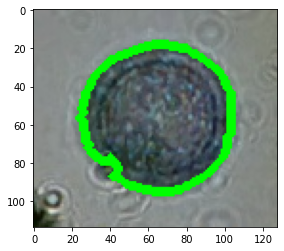

In [8]:
# we have the contours of just the biggest object: likely to be the plankton examined
img1 = volvox_train[190].copy()
img1_bin = volvox_train_bin[190].copy()
contour = contour_of_biggest_area(img1_bin)
cv2.drawContours(img1, contour, -1, (0, 255, 0), 3)
plt.imshow(img1)

For the features of the **minimum enclosing rectangle**, we can consider:
- area (in pixels)
- perimeter
- rectangularity = $\frac{\text{perimeter of the rectangle}}{\text{perimeter of the convex hull}}$
- shape factor = $\frac{\text{shorter side}}{\text{longer side}}$
- shorter side
- longer side

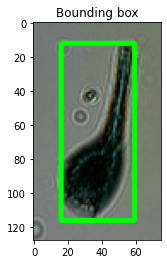

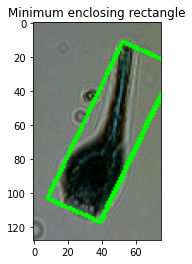

In [9]:
# show the slight difference between the bounding box and minimum
# enclosing rectangle (can be rotated by an angle)

img2 = stentor_train[9].copy()
img2_bin = stentor_train_bin[9].copy()
contour = contour_of_biggest_area(img2_bin)
rect = cv2.boundingRect(contour)
x, y, w, h = rect
cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.title("Bounding box")
plt.imshow(img2)
plt.show()


img2 = stentor_train[9].copy()
img2_bin = stentor_train_bin[9].copy()
contour = contour_of_biggest_area(img2_bin)
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img2, [box], 0, (0, 255, 0), 2)
plt.title("Minimum enclosing rectangle")
plt.imshow(img2)
plt.show()

In [10]:
def rectangle_features(img):
    
    assert len(np.unique(img.flatten())) == 2 # must be binary image
    
    cont = contour_of_biggest_area(img)
    # area as number of pixels inside the bounding rectangle
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.countNonZero(img[y:(y + h), x:(x + w)])
    # perimeter of the rectangle
    perimeter = cv2.arcLength(cont, True)
    
    min_rect = cv2.minAreaRect(cont) # x, y, w, h and angle of the minimum enclosing box
    box = cv2.boxPoints(min_rect) # coordinates of vertices of that box
    x1, y1 = box[0, :]
    x2, y2 = box[1, :]
    x3, y3 = box[2, :]
    
    # rectangularity
    convex_hull = cv2.convexHull(cont) # it is the convex approximation of the contour
    rectangularity = perimeter / cv2.arcLength(convex_hull, True)
    
    # length of the sides, using pythagoras theorem
    width = np.sqrt((x2 - x1) **  2 + (y2 - y1) ** 2)
    height = np.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    
    # compute minimum/maximum axis and their ratio
    if width > height:
        shape_factor = width / height
        max_axis = width
        min_axis = height
    else:
        shape_factor = height / width
        max_axis = height
        min_axis = width
    
    return area, perimeter, rectangularity, shape_factor, max_axis, min_axis

rectangle_features(stentor_train_bin[25].copy())

(1743, 253.5807341337204, 1.086799551706025, 3.21875, 103.0, 32.0)

For the features of the **minimum enclosing ellipse**, we can consider:
- minor axis $m$
- major axis $M$
- eccentricity $\frac{\sqrt{(\frac{M}{2})^2 - (\frac{m}{2})^2}}{M}$


In [11]:
def ellipse_features(img):
    
    assert len(np.unique(img.flatten())) == 2 # must be binary image
    
    cont = contour_of_biggest_area(img)
    ellipse = cv2.fitEllipse(cont)
    (center_x, center_y), axes, angle = ellipse
    minor_axis = min(axes)
    major_axis = max(axes)
    eccentricity = np.sqrt((major_axis / 2) ** 2 - (minor_axis / 2) ** 2) / major_axis

    return minor_axis, major_axis, eccentricity

print(ellipse_features(volvox_train_bin[0].copy()))
print(ellipse_features(stentor_train_bin[0].copy()))

(76.7376937866211, 81.49842834472656, 0.16838777948090106)
(29.034635543823242, 99.23733520507812, 0.4781208697522733)


## Moments
Moments are image descriptors derived from weighted average of the image pixels' intensities, that usually describe some object properties (after image segmentation), like its centroid or orientation. The "raw" (no function applied to $I(x,y)$) ij-th moment of an image is defined as:

$M_{ij} = \sum_x \sum_yx^i y^j I(x,y)$

From this, it's easy to see how $M_{00}$ is the sum of grayscale values in the image, and for a segmented object,
$\bar{x},\bar{y} = \frac{M_{10}}{M_{00}} , \frac{M_{01}}{M_{00}}$ are the coordinates of its centroid.

### Hu moments
Moments with invariance to translation and scale can be defined:

$
\eta_{ij}=\sum_x\sum_y(x-\bar x)^i (y- \bar y)^j I(x,y)\\
\mu_{ik}=\frac{\eta_{ij}}{\eta_{00}^\gamma},\gamma=\frac{i+j}{2}\\
$

however Hu Moments are the only ones that are also rotation invariant. They are constructed from scale invariant moments like so:

$
H_{1}   = \mu_{20} + \mu_{02}\\
H_{2}   = (\mu_{20} - \mu_{02})^2 + 4(\mu_{11})^2\\
H_{3} = (\mu_{30} - 3\mu_{12})^2 + (\mu_{03} - 3\mu_{21})^2\\
H_{4}  = (\mu_{30} + \mu_{12})^2 + (\mu_{03} + \mu_{21})^2\\
H_{5}  = (\mu_{30} - 3\mu_{12})(\mu_{30} + \mu_{12})[(\mu_{30} + \mu_{12})^2 - 3(\mu_{21} + \mu_{03})^2] + (3\mu_{21} - \mu_{03})(\mu_{21} + \mu_{03})[3(\mu_{30} + \mu_{12})^2 - (\mu_{03} + \mu_{21})^2]\\
H_{6}   = (\mu_{20} - \mu_{02})[(\mu_{30} + \mu_{12})^2 - (\mu_{21} + \mu_{03})^2] + 4\mu_{11}(\mu_{30} + \mu_{12})(\mu_{21} + \mu_{03})\\
H_{7} = (3\mu_{21} - \mu_{03})(\mu_{30} + \mu_{12})[(\mu_{30} + \mu_{12})^2 - 3(\mu_{21} + \mu_{03})^2] + (\mu_{30} - 3\mu_{12})(\mu_{21} + \mu_{03})[3(\mu_{30} + \mu_{12})^2 - (\mu_{03} + \mu_{21})^2]
$

The first one, $H_1$, is analogous to the moment of inertia around the image's centroid, where the pixels' intensities are analogous to physical density. The first six, $H_1 ... H_6$, are reflection symmetric, i.e. they are unchanged if the image is changed to a mirror image. The last one, $H_7$, is reflection antisymmetric (changes sign under reflection), which enables it to distinguish mirror images of otherwise identical images.

In [12]:
def hu_moments(img):
    assert len(np.unique(img.flatten())) == 2 # must be binary image
    
    cont = contour_of_biggest_area(img)
    moments = cv2.moments(cont)
    hu_moments = cv2.HuMoments(moments)
    return hu_moments.flatten()

hu_moments(stentor_train_bin[0].copy())

array([4.14451218e-01, 1.28248761e-01, 4.20516570e-02, 3.03882500e-02,
       1.08586912e-03, 1.07328062e-02, 3.06209352e-05])

### Zernike moments
Zernike polynomials are polynomials that form an orthogonal base with respect to the unit circle, and they are often used in the optics field to describe lenses' properties or irregularities. They can be considered with an arbitrary precision (much like when using bins/nffts when computing the DFT of an image).

Considering that our images are not cricle-like, we have to make a compromise: the best aproximation is to consider the circle centered at the center or the image, with radius equal to half the smallest image size (height/width).
![Visualization of Zernike polynomials](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Zernike_polynomials_with_read-blue_cmap.png/540px-Zernike_polynomials_with_read-blue_cmap.png)

In [13]:
!pip install mahotas

In [14]:
import mahotas as mh

def zernike_moments(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    width, height = grayscale.shape
    radius = min(width, height) // 2 # radius of largest circle fitting in the image
    return mh.features.zernike_moments(grayscale, radius)

print(zernike_moments(stentor_train[0].copy()))
print(len(zernike_moments(stentor_train[0].copy())))

[0.31830989 0.07830595 0.06954838 0.10082784 0.04427822 0.05551929
 0.04746974 0.09051899 0.06595944 0.01459211 0.0241032  0.02070999
 0.03991942 0.05599065 0.03235454 0.02363281 0.01997655 0.02100848
 0.03088643 0.02181531 0.04149663 0.05748972 0.02693153 0.02063728
 0.02746931]
25


### Image intensity features
#### Histogram-based features
Although histograms give a very global description of an image, some of their features can prove to be useful to classify its content, namely:
- histogram mean: $\mu = \frac{\sum_{i=0}^N{n_i m_i}}{N} $
- histogram standard deviation: $\sigma = \sqrt{\frac{\sum_{i=0}^N{n_i (m_i - \mu)^2}}{N}}$
- histogram skew: how much asimmetric is the histogram: $\frac{b_3}{b_2 ^ {3/2}}$
- histogram kurtosis: how much the tails of the distribution "weigh" compared to the rest: $\frac{\sum_{i=0}^N{(m_i-\mu)^4/N}}{\sigma ^4}-3$
- histogram entropy: $-\sum_{i=0}^N{m_i\log(\frac{m_i}{w(m_i)}})$

Where:

$n_i$: The frequency of the i-th bin

$m_i$: The midpoint/value of the i-th bin

$w_i$: The width of the i-th bin: always 1 in our case

$N$: The total sample size

$b_i$: The biased i-th central moment: $\frac{1}{N}\sum_{i=0}^N (m_i - \mu)^i$

In [15]:
import scipy.stats as sps

def histogram_features(img, img_mask):
    
    # turn image to grayscale and compute histogram (all 255 bins) on the masked regions
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # small fix for some images that lack a row
    img_mask = cv2.resize(img_mask, (grayscale.shape[1], grayscale.shape[0]), interpolation=cv2.INTER_AREA)
    
    histogram = cv2.calcHist([grayscale], [0], img_mask, [255], [0, 255])

    # histogram mean and std
    mean = histogram.mean()
    std_dev = histogram.std()
    # skewness and kurtosis
    hist_skew = sps.skew(histogram)[0]
    hist_kurtosis = sps.kurtosis(histogram)[0]
    histogram = histogram / np.max(histogram)
    # entropy
    hist_entropy = sps.entropy(histogram)[0]
    return mean, std_dev, hist_skew, hist_kurtosis, hist_entropy


histogram_features(paramecium_train[3].copy(), paramecium_train_bin[3].copy())

(5.301961, 7.7093654, 1.3281844, 0.58029985, 4.5448227)

#### Color-based features
Since the images are acquired in full RGB, we can take advantage of the biological color difference between the different creatures. For example, we can consider the average quantity of each of the 3 channels, and take their ratios.

In [16]:
def color_features(img, img_mask):
    
    assert len(np.unique(img_mask.flatten())) == 2 # mask must be binary image
    assert len(img.shape) == 3 # img must be color image
    
    # to be more precise, exclude (black) the parts where plankton is not
    # present by using the binary mask
    
     # small fix for some images that lack a row
    img_mask = cv2.resize(img_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
    
    # consider RGB values only from the masked regions (plankton subject)
    R = img[:,:,0] & img_mask
    G = img[:,:,1] & img_mask
    B = img[:,:,2] & img_mask

    R_over_B = np.mean(R) / np.mean(B)
    R_over_G = np.mean(R) / np.mean(G)
    G_over_B = np.mean(G) / np.mean(B)
    
    return R_over_B, R_over_G, G_over_B
    
color_features(stentor_train[0].copy(), stentor_train_bin[0].copy())

(1.5589246836840942, 1.180968543837843, 1.320039125358912)

### Haralick/GSCM features
GSCM features aim to extract information about the textural properties of an image (often, just of a uniformly textured part of it). For example, let's consider the GSCM (GrayScale Co-occurrence Matrix) $G$ with a shift of 1 horizontal pixel: that will be a 255 x 255 matrix containing information about the frequency of the grayscale values that occur when considering pairs of neighboring left-right pixels.

$G(i,j) = \# \{(x,y)|f(x,y)=i \land f(x+dx,y+dx)=j\}$

In the example above, $dx=1$ and $dy=0$, and for example $G(1,2)$ will contain the number of neighboring pixels (according to chosen shift) that have values 1 and 2. A visual demonstration:

![Example of GSCM](https://www.researchgate.net/publication/330550795/figure/fig1/AS:718062345011200@1548210812756/Haralick-texture-features-are-calculated-from-the-gray-level-co-occurrence-matrix-GLCM.jpg)


Robert Martin Haralick in 1973 proposed 14 statistical measures to summarize this matrix, providing an alternative to Gabor filters in texture descriptions. They include:

- Angular Second Moment $\sum_i\sum_j G(i,j)$
- Correlation $\frac{\sum_i\sum_j (ij)G(i,j)-\mu_i\mu_j}{\sigma_x\sigma_y}$
- Entropy $-\sum_i\sum_j G(i,j) log (G(i,j))$

To make the features more robust to changes in the image, we can compute the mean of those when considering different types of "neighboring" (namely, considering diagonal or vertical adjacency 4 directions will improve the robustness to rotation, and considering an integer scaling factor for $dx$ and $dy$ will improve the robustness to scaling).


Note 1: The matrix $G$ is often renormalized or computed on a quantized version of the grayscale image, to decrease its sparsity and size.

Note 2: The last Haralick descriptor (Maximal Correlation Coefficent) has proven to be unstable, so we can exclude it.

In [17]:
import mahotas as mt

def haralick_features(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = mt.features.haralick(grayscale) # shape 13 x 4
    return np.mean(features, axis=0) # average along "neighboring" directions

print(len(haralick_features(stentor_train[0].copy())))

13


### Local Binary Patterns
They summarize structures of the image (again describing textures) comparing each pixel to its $P$ uniformly distributed neighbors on a circle with radius $R$, where the point considered is the center. In this way, we associate each pixel to a value

$\sum_{p=0}^{P-1}s(g_p-g_c)2^p$

where $g_c$ is the point we are computing the LBP code of, and

$s(x)=\begin{cases}1 & \mbox{if x>0} \\ 0 & otherwise\end{cases}$

![Local Binary Pattern example](https://ebrary.net/htm/img/39/342/21.png)

From this matrix as big as the original image, containing LBP values/codes for each pixel, we can compute an histogram as descriptor (for example, I take the number of bins equal to $P$).

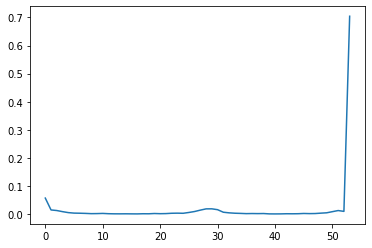

In [18]:
from skimage import feature

def local_binary_patterns(img):
    R, P = 8, 54
    
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    LBPs = feature.local_binary_pattern(grayscale, P, R, method="uniform")

    hist, _ = np.histogram(LBPs, bins=P)
    
    # normalize the histogram, adding a small value to denominator to prevent division by zero
    hist = hist / (hist.sum() + 0.001)
    
    return hist

lbp = local_binary_patterns(arcella_train[0])
plt.plot(lbp)

# actually, from plotting many LBPs for different planktons, I saw that the only
# part that discriminates them is the middle "bump": they all have a peak of
# values in the end and the rest is quite flat. Using the masked version
# of the same image doesn't seem to help.

# Visualization
Let's apply PCA on the selected features to try and get a visualization of how the classes are distributed: if we can see distinct clusters, we can get a good accuracy with unsupervised-semisupervised techniques

In [19]:
def get_all_features(img, img_bin):
    
    rect_f = rectangle_features(img_bin)
    ellp_f = ellipse_features(img_bin)
    hu_mom = hu_moments(img_bin)
    zk_mom = zernike_moments(img)
    hist_f = histogram_features(img, img_bin)
    colr_f = color_features(img, img_bin)
    hrlk_f = haralick_features(img)
    lcl_bp = local_binary_patterns(img)
    
    features = np.hstack([rect_f, ellp_f, hu_mom, zk_mom, hist_f, colr_f, hrlk_f, lcl_bp])
    #print([len(a) for a in [rect_f, ellp_f, hu_mom, zk_mom, hist_f, colr_f, hrlk_f, lcl_bp]])
    return features
    
f = get_all_features(stentor_train[0], stentor_train_bin[0])
print("A total of", len(f), "features")

A total of 116 features


In [20]:
from sklearn.preprocessing import StandardScaler

up_to = 500

f1 = np.array([get_all_features(stentor_train[i], stentor_train_bin[i]) for i in range(up_to)])
f2 = np.array([get_all_features(paramecium_train[i], paramecium_train_bin[i]) for i in range(up_to)])
f3 = np.array([get_all_features(didinium_train[i], didinium_train_bin[i]) for i in range(up_to)])
f4 = np.array([get_all_features(volvox_train[i], volvox_train_bin[i]) for i in range(up_to)])
f5 = np.array([get_all_features(arcella_train[i], arcella_train_bin[i]) for i in range(up_to)])

# normalize the features
f = np.vstack([f1, f2, f3, f4, f5])
scaler = StandardScaler()
f = scaler.fit_transform(f)

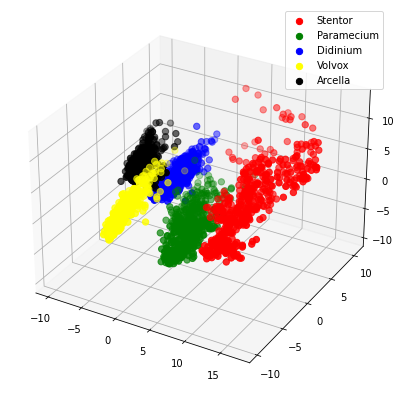

In [21]:
from sklearn.decomposition import PCA

# prepare labels for plot
y1 = np.ones(up_to)
y2 = np.ones(up_to) * 2
y3 = np.ones(up_to) * 3
y4 = np.ones(up_to) * 4
y5 = np.ones(up_to) * 5
y = np.hstack([y1, y2, y3, y4, y5])
cdict = {1:'red', 2:'green', 3:'blue', 4:'yellow', 5:'black'}

# apply PCA
pca = PCA(n_components=3)
f_pca = pca.fit_transform(f)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
for l in np.unique(y):
    ix = np.where(y==l)
    ax.scatter(f_pca[:,0][ix], f_pca[:,1][ix], f_pca[:,2][ix], c=cdict[l], s=40)
plt.legend(["Stentor", "Paramecium", "Didinium", "Volvox", "Arcella"])

In [22]:
import plotly.express as px
import pandas as pd

# interactive visualization of the same data, to see clusters from different perspectives
y_names = map(lambda x: {1:"Stentor", 2:"Paramecium", 3:"Didinium", 4:"Volvox", 5:"Arcella"}[x], y)
df = pd.DataFrame(zip(f_pca[:,0].T, f_pca[:,1].T, f_pca[:,2].T, y_names), columns=['PC1', 'PC2', 'PC3', 'species'])
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='species')
fig.show()

# Anomaly detection
Anomaly detection is a technique of discriminating data as standard/non-standard (or more in general, belonging or not to a certain category) with an unsupervised approach. In this section, I'm going to use different models typically used in Anomaly Detection problems to discriminate between 1 class of plankton (on which the model has to be trained) and the rest.

The key concept is to train a model for each known plankton type: when deployed and once analyzed new data, if none of the models predicts the belonging to its own class, we can consider it an anomaly. This could happen when a new type of plankton is examined, or when some plankton is dead/so deteriorated that its visual properties result very different: this can help experts in evaluating the type of plankton population in one area, or estimating the quality of the water based on the structure/"liveness" of the plankton.

## One class SVM
In classical binary classification tasks (where we can have balanced datasets with enough points for each of the 2 classes), an SVM aims to find the best separation boundary, maximizing its distance with respect to the points in each of the 2 classes.

In anomaly detection tasks, we can consider the optimal boundary as an hypersurface containing the points of the only class. Any point outside that boundary, will be considered an outlier/anomaly.
The regularization parameter in classical SVM ($C$ in many formulations) is here replaced by $\nu$ (nu), but still keeps a similar meaning: it controls how many outliers we want to allow.

![SVM illustration](https://miro.medium.com/max/554/1*-40O3CMtJ5bms0sGumcr8g.png)

In [23]:
scaler = StandardScaler()
scaler.fit(f)
f1 = scaler.transform(f1)
f2 = scaler.transform(f2)
f3 = scaler.transform(f3)
f4 = scaler.transform(f4)
f5 = scaler.transform(f5)

In [24]:
from sklearn.svm import OneClassSVM

def train_and_evaluate(model, features, categories, test_set):
    # trains a One-class SVM on the specified samples
    # (1 flag in categories) and evaluates it on the other
    # samples (-1 flag in categories)
    
    # find the samples on which we need to train (no anomaly)
    pos_i = categories.index(1)
    positive_samples = features[pos_i]
    
    # fit the model
    clf = model.fit(positive_samples)
    
    # evaluate how good is the prediction for each of the other categories
    precisions = []
    for i, samples in enumerate(test_set):
        pred = clf.predict(samples)
        # differenciating when computing the precision
        if i == pos_i:
            precision = np.count_nonzero(pred == 1) / len(samples)
            print(f"On positive class ({i}):", precision, "accuracy")
        else:
            precision = np.count_nonzero(pred == -1) / len(samples)
            print(f"On negative class ({i}):", precision, "accuracy")
        precisions.append(precision)
    return precisions

# evaluation on the training set
# hyperparameter nu was obtained via cross-validation, comparing mean accuracies
# on the positive classes
SVM = OneClassSVM(nu=0.1, kernel="rbf")

print("Anomaly detection on Stentor:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [1, -1, -1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Paramecium:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, 1, -1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Didinium:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, 1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Volvox:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, -1, 1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Arcella:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, -1, -1, 1], [f1, f2, f3, f4, f5])

Anomaly detection on Stentor:
On positive class (0): 0.9 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 0.474 accuracy
On negative class (3): 0.998 accuracy
On negative class (4): 0.634 accuracy

Anomaly detection on Paramecium:
On negative class (0): 1.0 accuracy
On positive class (1): 0.898 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Didinium:
On negative class (0): 0.638 accuracy
On negative class (1): 1.0 accuracy
On positive class (2): 0.9 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 0.116 accuracy

Anomaly detection on Volvox:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On positive class (3): 0.9 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Arcella:
On negative class (0): 0.666 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 0.098 accuracy

[0.666, 1.0, 0.098, 1.0, 0.902]

We can see how the two close apart clusters in the PCA (Arcella and Didinium) have their corresponding models tending to consider the samples for the other class as not-anomalies: many Arcellas are identified as normal by the Didinium model, and vice-versa. Also visually, they look quite the same.

The more spread-apart cluster, Stentor, has good positive accuracy but bad anomaly accuracy with respect to some of the other planktons: I suspect this has to do with the "incoherentness" of the points of that plankton, that lead the model to consider a boundary too large.

We could get better results if we fine-tuned each of the models with its optimal hyperparameter, but that's not a scalable approach, if we consider keep adding to the dataset new plankton species as we discover them, or if we have many more species than 5.

## Isolation Forest
Isolation Forests are a very scalable algorithm, especially in high dimentional datasets. They rely on Decision Trees, "grown" randomly.
At each step, a feature is randomly selected and a random threshold value is decided (between min and max) to split the dataset in two: this procedure is repeated until all the dataset is gradually "chopped" into pieces, with each observation isolated from the others.

Anomalies, being far from the rest of the observations, will get isolated in less steps than normal observations: we can then calculate (for each tree in the forest) an Anomaly Score for the new point, based on the height of its position in the tree.

![Isolation Forest](https://miro.medium.com/max/1400/1*D78QLbcwXesymhquuofnOg.png)

In [25]:
from sklearn.ensemble import IsolationForest
            
    
IF = IsolationForest(random_state=0)

print("Anomaly detection on Stentor:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [1, -1, -1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Paramecium:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, 1, -1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Didinium:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, 1, -1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Volvox:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, -1, 1, -1], [f1, f2, f3, f4, f5])
print("\nAnomaly detection on Arcella:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, -1, -1, 1], [f1, f2, f3, f4, f5])

Anomaly detection on Stentor:
On positive class (0): 0.936 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Paramecium:
On negative class (0): 1.0 accuracy
On positive class (1): 0.958 accuracy
On negative class (2): 0.982 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Didinium:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On positive class (2): 0.978 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Volvox:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On positive class (3): 0.94 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Arcella:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On neg

[1.0, 1.0, 1.0, 1.0, 0.934]

The results are much better: almost no anomaly is detected as normal, and also the "positive" precision has increased. With respect to the SVM. Let's also test on the test set.

In [26]:
volvox_test = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGE\VOLVOX", binarize=False)
paramecium_test = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGE\PARAMECIUM  BURSARIA", binarize=False)
didinium_test = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGE\DIDINIUM NASUTUM", binarize=False)
arcella_test = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGE\ARCELLA VULGARIS", binarize=False)
stentor_test = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGE\STENTOR COERULEUS", binarize=False)

volvox_test_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGEBIN\VOLVOX", binarize=True)
paramecium_test_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGEBIN\PARAMECIUM  BURSARIA", binarize=True)
didinium_test_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGEBIN\DIDINIUM NASUTUM", binarize=True)
arcella_test_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGEBIN\ARCELLA VULGARIS", binarize=True)
stentor_test_bin = load_images_from_folder(".\DATA\LENSLESS DATASET\TEST_IMAGEBIN\STENTOR COERULEUS", binarize=True)

up_to_test = 140

f1_test = np.array([get_all_features(stentor_test[i], stentor_test_bin[i]) for i in range(up_to_test)])
f2_test = np.array([get_all_features(paramecium_test[i], paramecium_test_bin[i]) for i in range(up_to_test)])
f3_test = np.array([get_all_features(didinium_test[i], didinium_test_bin[i]) for i in range(up_to_test)])
f4_test = np.array([get_all_features(volvox_test[i], volvox_test_bin[i]) for i in range(up_to_test)])
f5_test = np.array([get_all_features(arcella_test[i], arcella_test_bin[i]) for i in range(up_to_test)])

# normalize the features
f_test = np.vstack([f1_test, f2_test, f3_test, f4_test, f5_test])
scaler = StandardScaler()
f_test = scaler.fit_transform(f_test)

scaler = StandardScaler()
scaler.fit(f_test)
f1_test = scaler.transform(f1_test)
f2_test = scaler.transform(f2_test)
f3_test = scaler.transform(f3_test)
f4_test = scaler.transform(f4_test)
f5_test = scaler.transform(f5_test)

In [27]:
print("Anomaly detection on Stentor:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [1, -1, -1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Paramecium:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, 1, -1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Didinium:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, 1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Volvox:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, -1, 1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Arcella:")
train_and_evaluate(SVM, [f1, f2, f3, f4, f5], [-1, -1, -1, -1, 1], [f1_test, f2_test, f3_test, f4_test, f5_test])

Anomaly detection on Stentor:
On positive class (0): 0.8214285714285714 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 0.4714285714285714 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 0.6785714285714286 accuracy

Anomaly detection on Paramecium:
On negative class (0): 1.0 accuracy
On positive class (1): 0.4 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Didinium:
On negative class (0): 0.6 accuracy
On negative class (1): 1.0 accuracy
On positive class (2): 0.9214285714285714 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 0.15 accuracy

Anomaly detection on Volvox:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On positive class (3): 0.29285714285714287 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Arcella:
On negative class (0): 0.5714285714285714 accu

[0.5714285714285714, 1.0, 0.04285714285714286, 1.0, 0.8857142857142857]

In [28]:
print("Anomaly detection on Stentor:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [1, -1, -1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Paramecium:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, 1, -1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Didinium:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, 1, -1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Volvox:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, -1, 1, -1], [f1_test, f2_test, f3_test, f4_test, f5_test])
print("\nAnomaly detection on Arcella:")
train_and_evaluate(IF, [f1, f2, f3, f4, f5], [-1, -1, -1, -1, 1], [f1_test, f2_test, f3_test, f4_test, f5_test])

Anomaly detection on Stentor:
On positive class (0): 0.8285714285714286 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Paramecium:
On negative class (0): 1.0 accuracy
On positive class (1): 0.8 accuracy
On negative class (2): 0.9714285714285714 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Didinium:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On positive class (2): 0.8857142857142857 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Volvox:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On positive class (3): 0.9214285714285714 accuracy
On negative class (4): 1.0 accuracy

Anomaly detection on Arcella:
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 

[1.0, 1.0, 1.0, 1.0, 0.9142857142857143]

We can see how the isolation forest performs best even on the test set

# Feature Selection
We have obtained good anomaly detection results with a total of 116 features for each image, but some of them are not independent from each other (for example, the length of the sides of the enclosing rectangle and the axes of the enclosing ellipse will be easily similar).

We can try to exclude some of the features considered above and see the most "useful" ones in the anomaly detection by measuring the difference of precision without them: the most important ones will be the ones that make the precision decrease the most.

For each group of features excluded (8 total), we have 5 models to test (1 for each plankton type), each evaluated on on each of the 5 classes: this leads a 3D space with 8x5x5 points, which can be difficult to visualize and to extract information form. To better tackle the problem of "which features are useful in discriminating a specific type of plankton", I chose not to reduce each model to 1 precision number (accuracy on its specific plankton species) and to keep each of the 5 precisions on each of the species; instead I average the precision for each plankton type along the 5 models (once for each group of features excluded).

This way, I end up with a 8x5 set of observations: for each group of features (8), I have an average measure of how much those features are important in discriminating that type of plankton (5).

Since with Isolation Forests the positive class (no-anomaly) seems to be the only one that has precision far from 100% (so we have 100% precision of models that should consider that specific species as anomaly, and <100% precision in the model that should detect it as non-anomaly), taking the minimum instead of the mean could also be a sensible choice.

In [29]:
def evaluate_with_less_features():
    
    feature_sizes = [6, 3, 7, 25, 5, 3, 13, 54]
    
    # precisions for specific plankton type, when removing i-th group of features
    precisions_stentor = np.zeros(8)
    precisions_paramecium = np.zeros(8)
    precisions_didinium = np.zeros(8)
    precisions_volvox = np.zeros(8)
    precisions_arcella = np.zeros(8)  
    
    for excluded_i in range(8):
        print("\n\nBy excluding feature group number", excluded_i)
        
        # build mask that identifies features to be kept
        cur_size = feature_sizes[excluded_i]
        prev_size = int(np.sum(feature_sizes[:excluded_i]))
        selected = np.ones(np.sum(feature_sizes), dtype=int)
        selected[prev_size:prev_size + cur_size] = 0
        # select features, creating copies of smaller size
        f1c = f1[:, selected==1]
        f2c = f2[:, selected==1]
        f3c = f3[:, selected==1]
        f4c = f4[:, selected==1]
        f5c = f5[:, selected==1]
        f1_testc = f1_test[:, selected==1]
        f2_testc = f2_test[:, selected==1]
        f3_testc = f3_test[:, selected==1]
        f4_testc = f4_test[:, selected==1]
        f5_testc = f5_test[:, selected==1]
        
        
        # compute precision scores using those features: we have 5 "precisions" for each run
        precisions1 = train_and_evaluate(IF, [f1c, f2c, f3c, f4c, f5c], [1, -1, -1, -1, -1], [f1_testc, f2_testc, f3_testc, f4_testc, f5_testc])
        precisions2 = train_and_evaluate(IF, [f1c, f2c, f3c, f4c, f5c], [-1, 1, -1, -1, -1], [f1_testc, f2_testc, f3_testc, f4_testc, f5_testc])
        precisions3 = train_and_evaluate(IF, [f1c, f2c, f3c, f4c, f5c], [-1, -1, 1, -1, -1], [f1_testc, f2_testc, f3_testc, f4_testc, f5_testc])
        precisions4 = train_and_evaluate(IF, [f1c, f2c, f3c, f4c, f5c], [-1, -1, -1, 1, -1], [f1_testc, f2_testc, f3_testc, f4_testc, f5_testc])
        precisions5 = train_and_evaluate(IF, [f1c, f2c, f3c, f4c, f5c], [-1, -1, -1, -1, 1], [f1_testc, f2_testc, f3_testc, f4_testc, f5_testc])
        prec = [precisions1, precisions2, precisions3, precisions4, precisions5]
        
        precisions_stentor[excluded_i] = np.mean([p[0] for p in prec])
        precisions_paramecium[excluded_i] = np.mean([p[1] for p in prec])
        precisions_didinium[excluded_i] = np.mean([p[2] for p in prec])
        precisions_volvox[excluded_i] = np.mean([p[3] for p in prec])
        precisions_arcella[excluded_i] = np.mean([p[4] for p in prec])
        
        
    return [precisions_stentor, precisions_paramecium, precisions_didinium, precisions_volvox, precisions_arcella]

In [30]:
precisions = evaluate_with_less_features()
precisions = np.array(precisions)



By excluding feature group number 0
On positive class (0): 0.8214285714285714 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy
On negative class (0): 1.0 accuracy
On positive class (1): 0.8071428571428572 accuracy
On negative class (2): 0.8785714285714286 accuracy
On negative class (3): 0.9857142857142858 accuracy
On negative class (4): 1.0 accuracy
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On positive class (2): 0.9071428571428571 accuracy
On negative class (3): 1.0 accuracy
On negative class (4): 1.0 accuracy
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On positive class (3): 0.9142857142857143 accuracy
On negative class (4): 1.0 accuracy
On negative class (0): 1.0 accuracy
On negative class (1): 1.0 accuracy
On negative class (2): 1.0 accuracy
On negative class (3): 1.0 accuracy
On posit

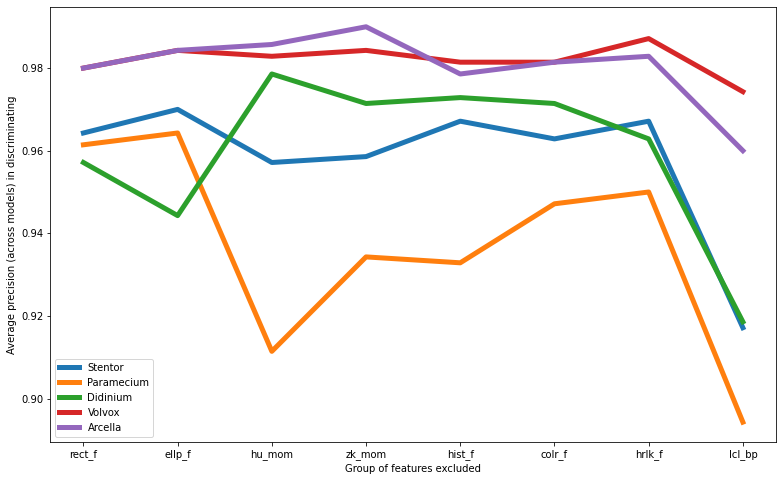

In [31]:
plt.figure(figsize=((13,8)))
for p in precisions:
    plt.plot(p, linewidth=5)

plt.legend(["Stentor", "Paramecium", "Didinium", "Volvox", "Arcella"])
plt.xlabel("Group of features excluded")
plt.ylabel("Average precision (across models) in discriminating")
feature_names = ["rect_f", "ellp_f", "hu_mom", "zk_mom", "hist_f", "colr_f", "hrlk_f", "lcl_bp"] 
plt.xticks(range(0,8), feature_names)
plt.show()

We can see that Zernike and elliptical features are not very useful for discriminating any of the plankton species (accuracy is high in all cases even without them): when designing a full feature extraction pipeline, we can consider to exclude them (or reduce their number) to reduce the dimensionality of the problem, saving space and time in spite of a minimal accuracy reduction. Hu moments seem to be very useful in classifying Paramecium specifically.

LBPs proved quite useful in all cases: the accuracy dropped the most when we excluded them, especially for Arcella. This could be also because of their high number, rather than their usefulness.

The most surprising thing I noticed is that Haralick features, when removed, do not cause any big accuracy drop in discriminating Volvox: It has a round shape like other ones, but a distinct "rough" visual pattern/texture that I thought would have been important. It might be that those type of texture information is already present in Local Binary Patterns.

I also expected ellipse and rectangle features to be more important since they directly encode the difference in shapes between long (Stentor and Paramecium) and round plankton.

By once again averaging along the plankton types, we can get an overall view on how much each feature helps in anomaly detection (again, high peaks mean low importance/ability to discriminate):

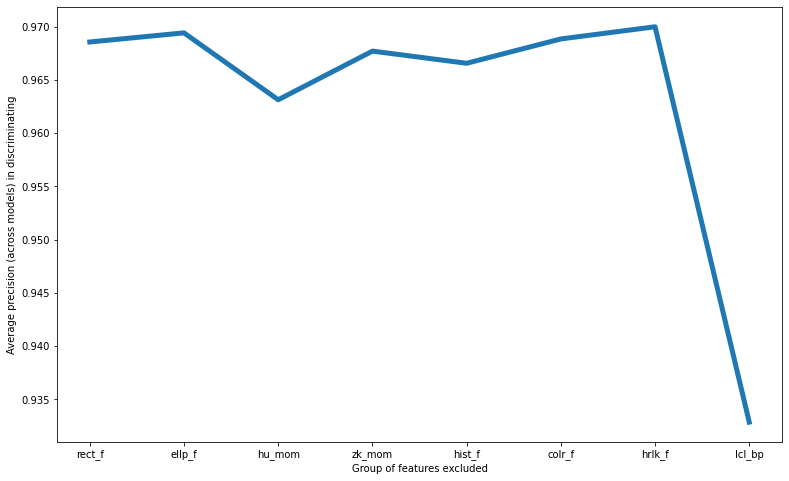

In [32]:
plt.figure(figsize=((13,8)))
plt.plot(precisions.mean(axis=0), linewidth=5)

plt.xlabel("Group of features excluded")
plt.ylabel("Average precision (across models) in discriminating")
plt.xticks(range(0,8), feature_names)
plt.show()

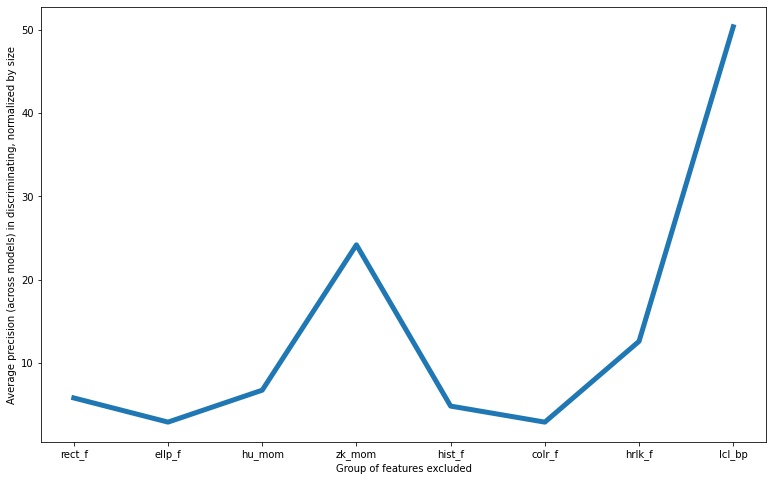

In [33]:
precisions_normalized = precisions.mean(axis=0) * [6, 3, 7, 25, 5, 3, 13, 54]

plt.figure(figsize=((13,8)))
plt.plot(precisions_normalized, linewidth=5)

plt.xlabel("Group of features excluded")
plt.ylabel("Average precision (across models) in discriminating, normalized by size")
plt.xticks(range(0,8), feature_names)
plt.show()

When we take into consideration the number of features for each group, it turns out that the other ones are actually more important, espescially color features and the ellipse ones.